# Earthquake location inversion

---
## What we do in this notebook

Here we demonstrate the inverse problem determing earthquake hypocentre.

Learning outcomes include:
- State the inverse problem for the hypocentre determination
- Solve the inverse problem in the optimal framework, by minimizing a misfit function
- Solve the inverse problem in the Bayesian framework with an advanced stochastic sampler

--- 
## Preparation
Here we follow the recipe described in Practical excercise in Day 2 to download waveform data of the M5 Kon Tum 28/07/2024 earthquake to demonstrate the example.

In [3]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

# Initialize the client for ISC
isc = Client("ISC")
# Request event information
event = isc.get_events(eventid="641665444")[0]
origin_time = event.preferred_origin().time
origin_lat = event.preferred_origin().latitude
origin_lon = event.preferred_origin().longitude

# Circular domain around the epicenter
domain = CircularDomain(origin_lat, origin_lon, minradius=0.0, maxradius=10.0)
# Restriction on the waveform data
restrictions = Restrictions(
    starttime=origin_time - 1 * 60,
    endtime=origin_time + 10 * 60,
    reject_channels_with_gaps=True,
    minimum_length=0.95,
    minimum_interstation_distance_in_m=150E3,
    channel_priorities=["BH[ZNE12XY]", "HH[ZNE]"],
    location_priorities=["", "00", "10"])

# Initialize the mass downloader with specific providers
mdl = MassDownloader(providers=['IRIS'])
mdl.download(domain, restrictions, mseed_storage="waveforms", stationxml_storage="stations")

[2025-03-20 23:31:11,749] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2025-03-20 23:31:12,083] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2025-03-20 23:31:12,084] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-03-20 23:31:12,084] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2025-03-20 23:31:15,430] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (3.35 seconds)
[2025-03-20 23:31:15,445] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 15 stations (45 channels).
[2025-03-20 23:31:15,447] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 11 stations.
[2025-03-20 23:31:15,448] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 24 time intervals/channels before downloading: EXIS

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7fc4fcc9bf10>}

Next, we load metadata and plot the map of station for sanity check.

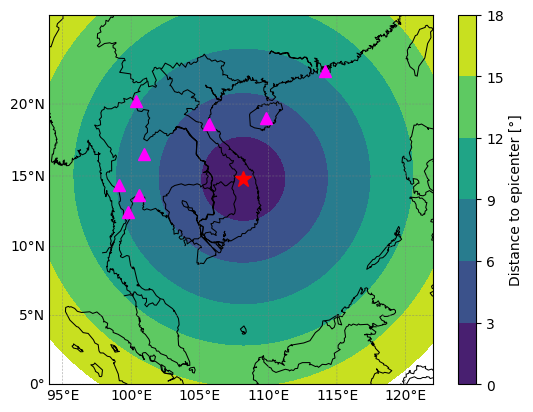

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

from obspy import read_inventory, Inventory
from pathlib import Path
inv = Inventory()
for file in Path("stations").glob("*.xml"): inv += read_inventory(str(file))

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='l')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the epicenter
m.plot(origin_lon, origin_lat, 'r*', markersize=12, label='Epicenter', latlon=True)

# plot the station locations
for network in inv:
    for station in network:
        lon = station.longitude
        lat = station.latitude
        m.plot(lon, lat, '^', c='magenta', markersize=8, latlon=True)

# plot distance contours to the epicenter
from obspy.geodetics import locations2degrees
x = np.linspace(m.xmin, m.xmax, 300)
y = np.linspace(m.ymin, m.ymax, 300)
mlon, mlat = m(*np.meshgrid(x, y), inverse=True)
dist = locations2degrees(origin_lat, origin_lon, mlat, mlon)
mapple = m.contourf(mlon, mlat, dist, levels=range(0, 19, 3), latlon=True, cmap='viridis')

# add a colorbar
plt.colorbar(mapple, label='Distance to epicenter [°]')

# show the plot
plt.show()

---
## Collection of seismic observations

In [10]:
picks = {}

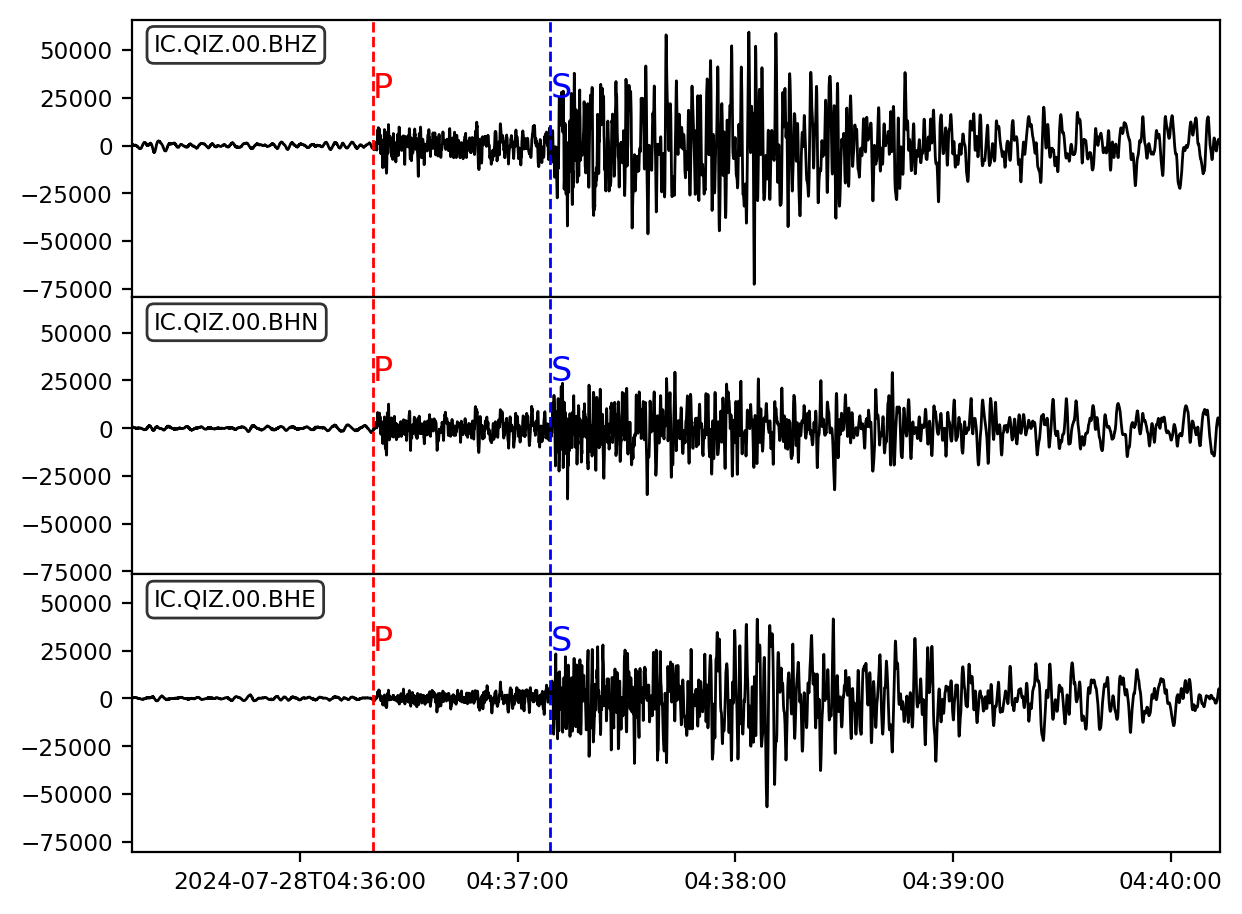

In [11]:
import matplotlib.dates as mdates
from datetime import datetime

fig1 = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*QIZ*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig1)

p_arr = datetime(2024,7,28,4,36,20)
s_arr = datetime(2024,7,28,4,37,9)

tmp = inv.select(station='QIZ')[0][0]
picks['QIZ'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr}

## plot the P and S arrival times
for ax in fig1.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)
fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))

plt.show()

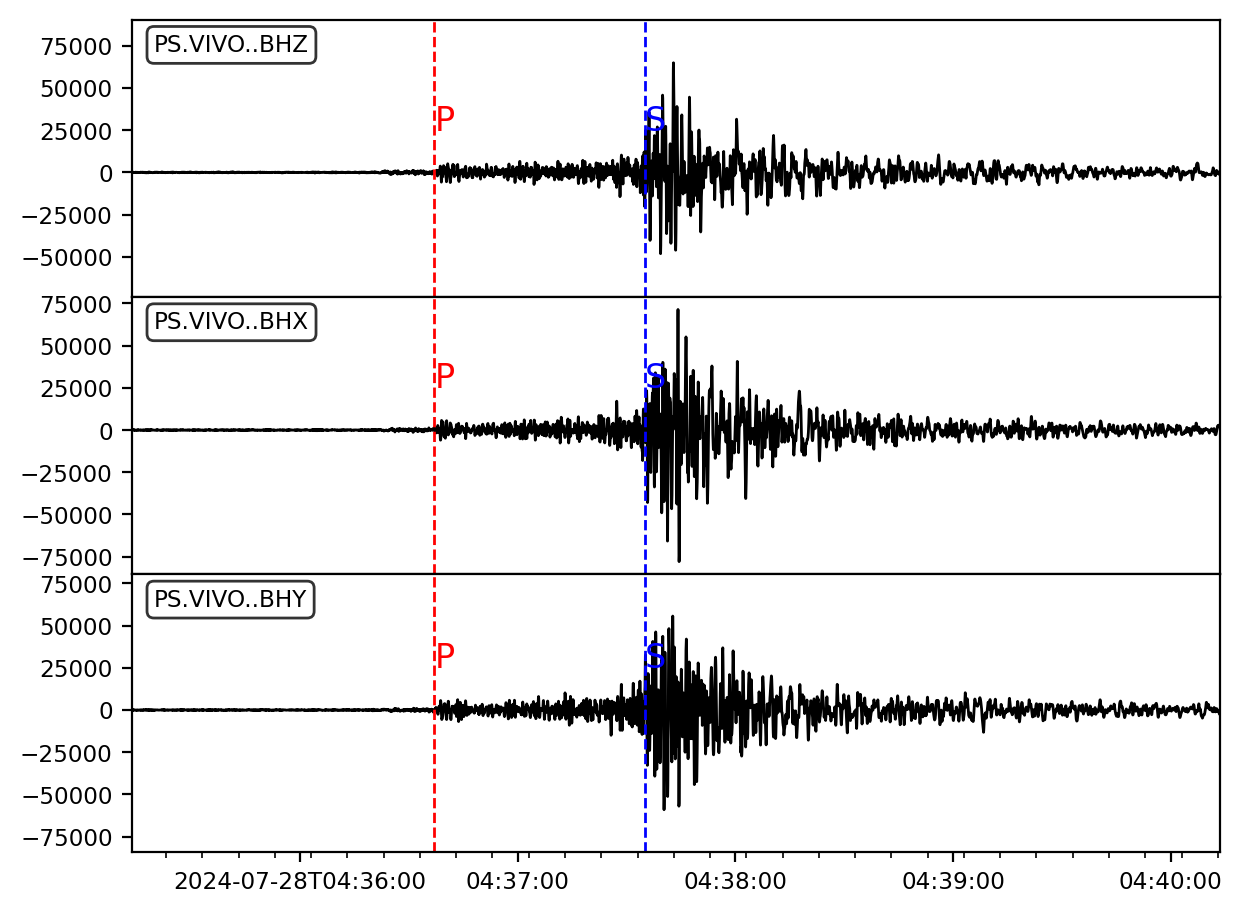

In [12]:
fig = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*VIVO*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig)

p_arr = datetime(2024,7,28,4,36,37)
s_arr = datetime(2024,7,28,4,37,35)

tmp = inv.select(station='VIVO')[0][0]
picks['VIVO'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr}
    
## plot the P and S arrival times
for ax in fig.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)

fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
plt.show()

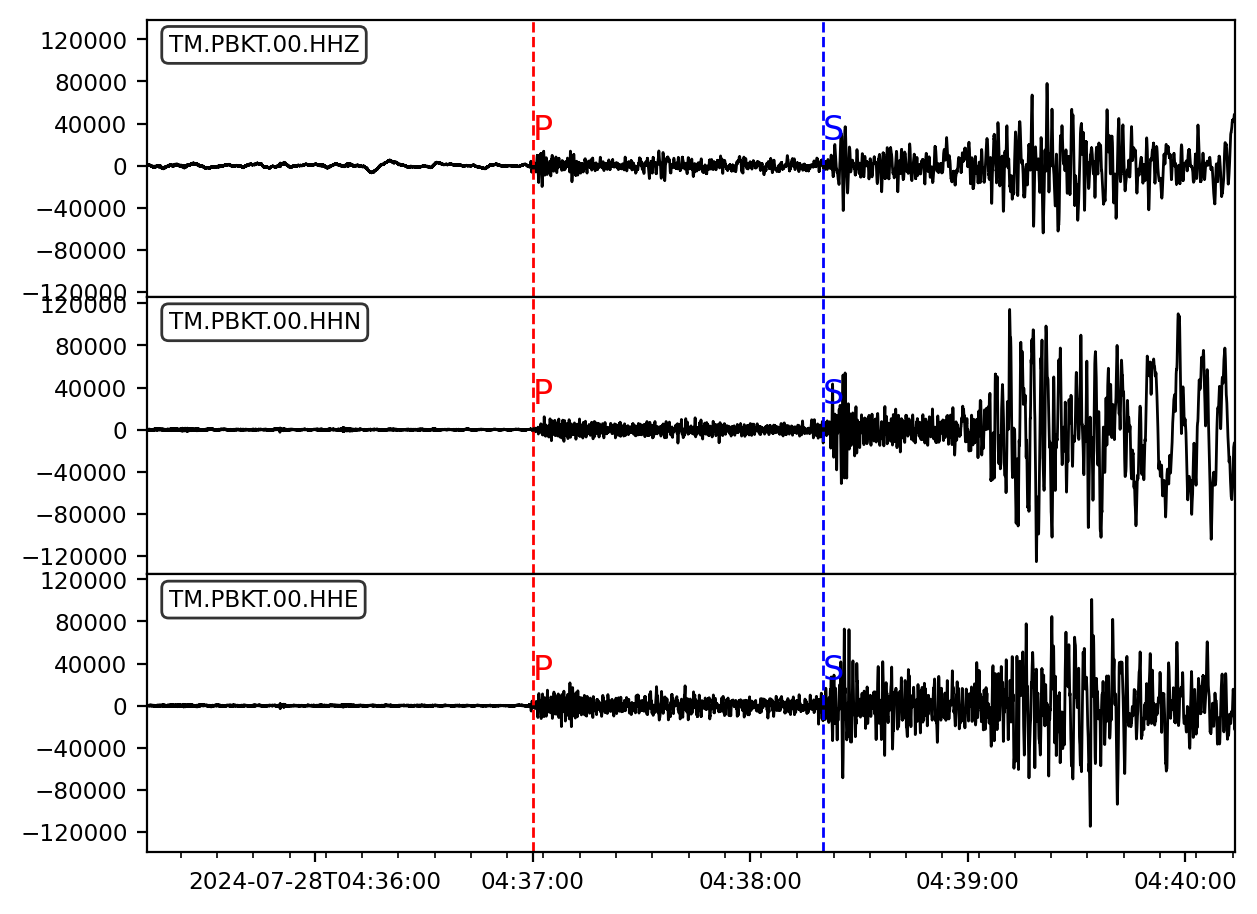

In [13]:
fig = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*PBKT*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig)

p_arr = datetime(2024,7,28,4,37,0)
s_arr = datetime(2024,7,28,4,38,20)

tmp = inv.select(station='PBKT')[0][0]
picks['PBKT'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr}

## plot the P and S arrival times
for ax in fig.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)

fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
# fig.axes[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
plt.show()

---
## Definite the forward problem

- input: hypocentral coordinates $(\theta, \phi)$
- ouput: differential travel time of S- and P- wave arrivals

We build the forward problem upon the `taup` software. `taup` is a classical package in global seismology to predict travel times of teleseismic phases in spherial Earth models. The package was origninally written in the Java programming language, which is packaged in `obspy` to allow pythonic interface.

In [ ]:
data = np.array([UTCDateTime(_['s_arr']) - UTCDateTime(_['p_arr']) for _ in picks.values()])

In [ ]:
from obspy.taup import TauPyModel
taup_model = TauPyModel(model="ak135")

For each hypocentral coordinate, the P and S travel time to each stations measured are computed using the taup `get_travel_times_geo` function. The prediction for each hypocentra will be S- to P- travel time differences corresponding to the observed stations.

In [ ]:
def forward_prob(S):
    '''
    This forward problem returns the differential travel times of the S wave
    and P wave for a given epicenter location S observed at three stations 
    QIZ, VIVO, PBKT.
    '''
    src_lat, src_lon = S
    output = []
    for rcv in picks.values():
        p_arvs = taup_model.get_travel_times_geo(0, src_lat, src_lon, rcv['lat'], rcv['lon'], phase_list=['P'])
        s_arvs = taup_model.get_travel_times_geo(0, src_lat, src_lon, rcv['lat'], rcv['lon'], phase_list=['S'])
        output.append(s_arvs[0].time - p_arvs[0].time)
    return np.array(output)

--- 
## Optimal inverse solution

The solu

In [16]:
## define the objective function
def objective_function(S):
    pred = forward_prob(S)
    return np.sum((data - pred)**2)

## optimize the epicenter location
from scipy.optimize import minimize
S0 = (origin_lat, origin_lon)
res = minimize(objective_function, x0=S0, method='Nelder-Mead')

print (res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 40.8056431533417
             x: [ 1.487e+01  1.083e+02]
           nit: 32
          nfev: 64
 final_simplex: (array([[ 1.487e+01,  1.083e+02],
                       [ 1.487e+01,  1.083e+02],
                       [ 1.487e+01,  1.083e+02]]), array([ 4.081e+01,  4.081e+01,  4.081e+01]))


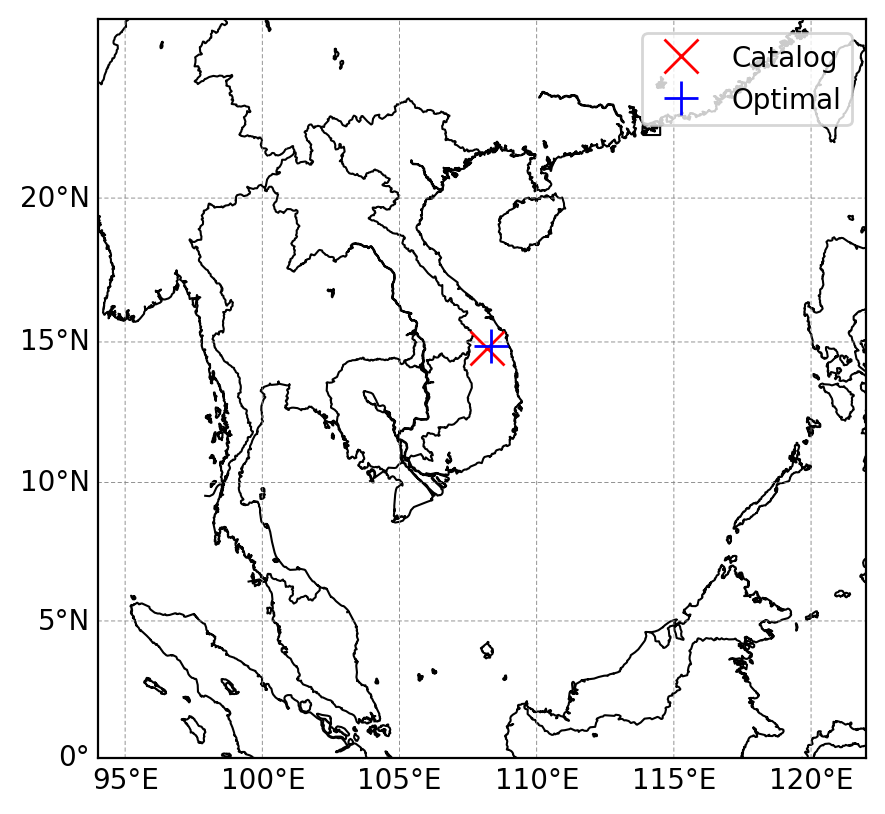

In [18]:
# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
# for key, val in picks.items():
    # m.plot(val['x'], val['y'], '^', c='magenta', markersize=8)/
    # ax.text(val['x'], val['y']+4e4, key, fontsize='small', color='r', ha='center')

# plot the epicenter
m.plot(S0[1], S0[0], 'x', markersize=12, label='Catalog', mec='r', latlon=True)

# plot the epicenter
m.plot(res.x[1], res.x[0], '+', markersize=12, label='Optimal', mec='b', latlon=True)

ax.legend()
# show the plot
plt.show()

# Bayesian sampling and uncertainty estimates

In [19]:
import emcee

## define the objective function
def log_prob(S):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    if not (0 <= S[0] <= 26 and 94 <= S[1] <= 122): return -np.inf
    pred = forward_prob(S)
    sigma = np.ones_like(data) * 5
    return -.5 * np.sum((data - pred)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))

## initialize the walkers
nwalkers = 6
ndim = 2
p0 = np.random.uniform(0, 1, (nwalkers, ndim))
p0[:, 0] *= 26
p0[:, 1] = 94 + p0[:, 1] * 28

## run the MCMC
nsteps = 200
from multiprocessing import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_prob, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


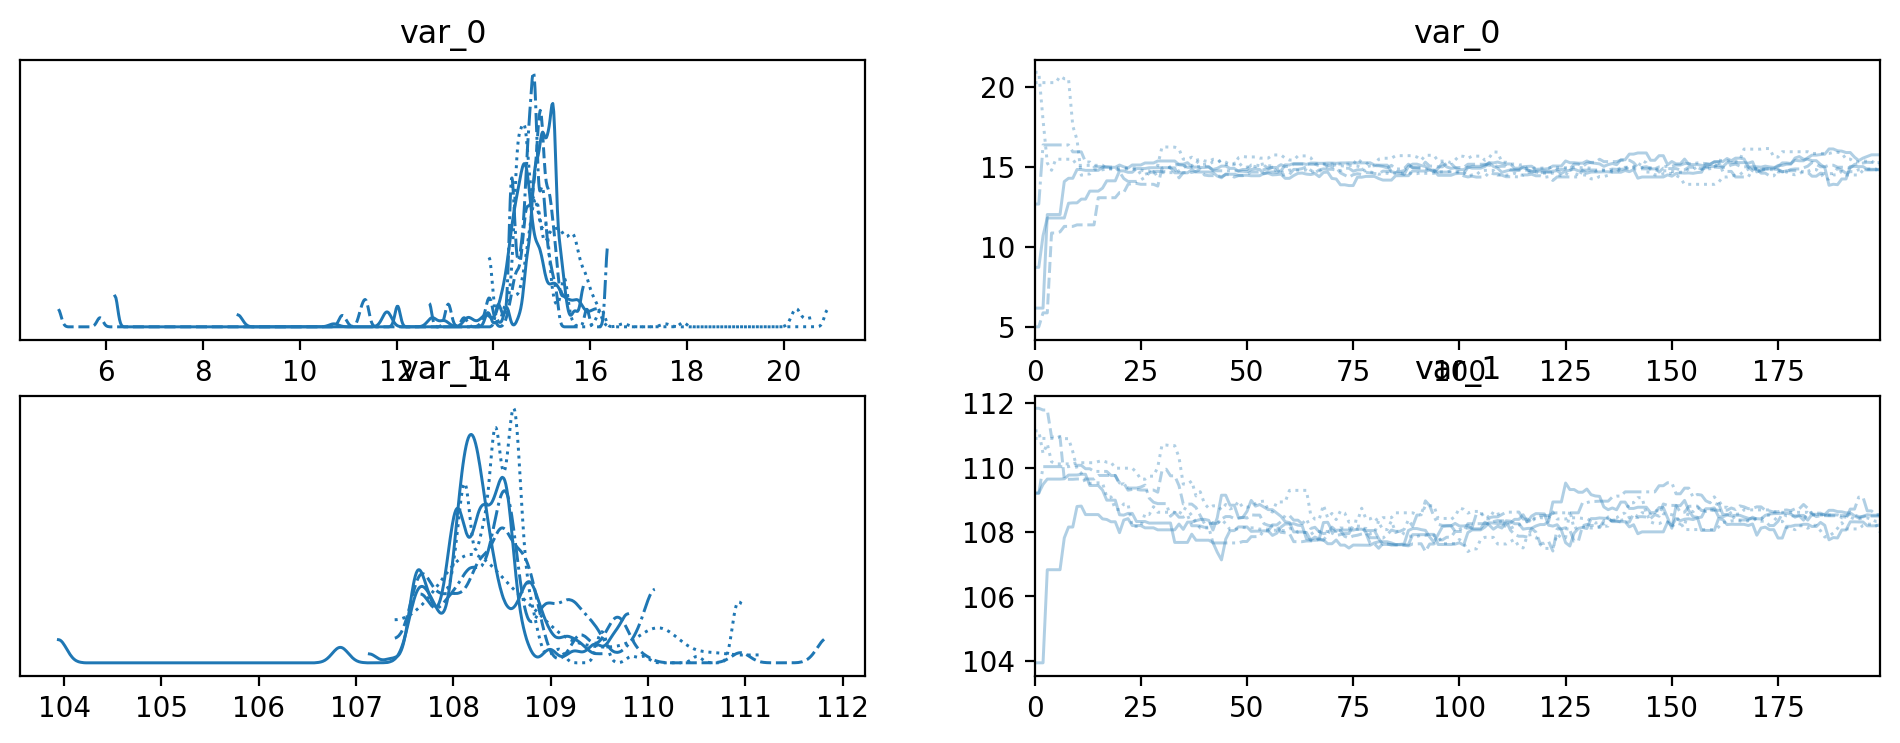

In [20]:
import arviz as az

data = az.from_emcee(sampler)
ax = az.plot_trace(data)
plt.show()

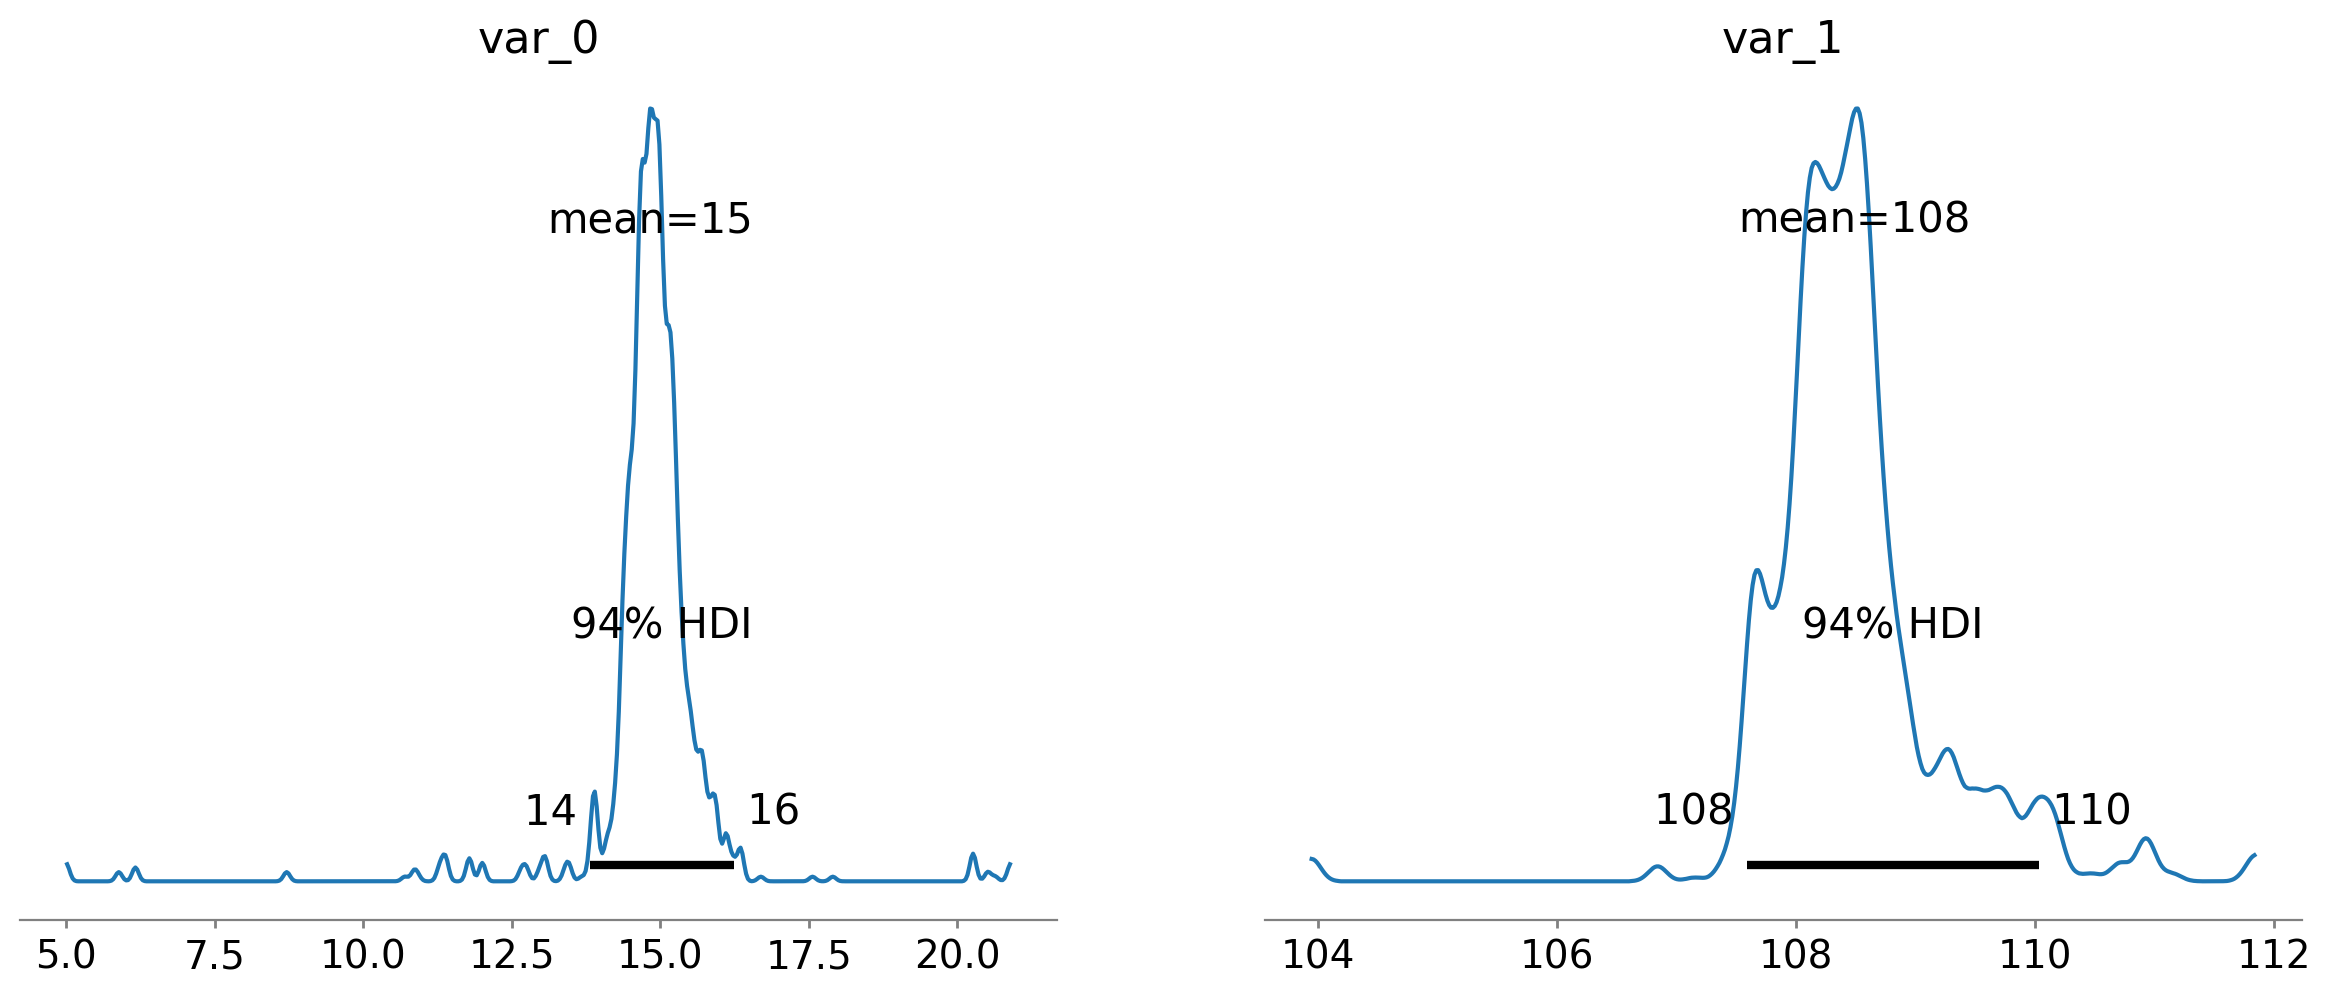

In [23]:
az.plot_posterior(data, point_estimate='mean', round_to=2)
plt.show()

In [ ]:
az.plot_pair(data.se 200),
    kind = 'kde', 
    kde_kwargs={
    'hdi_probs':[.1, .3, .5, .7, .9],
    'contour_kwargs': {'colors': 'Blues'}
})

SyntaxError: positional argument follows keyword argument (4119938555.py, line 1)

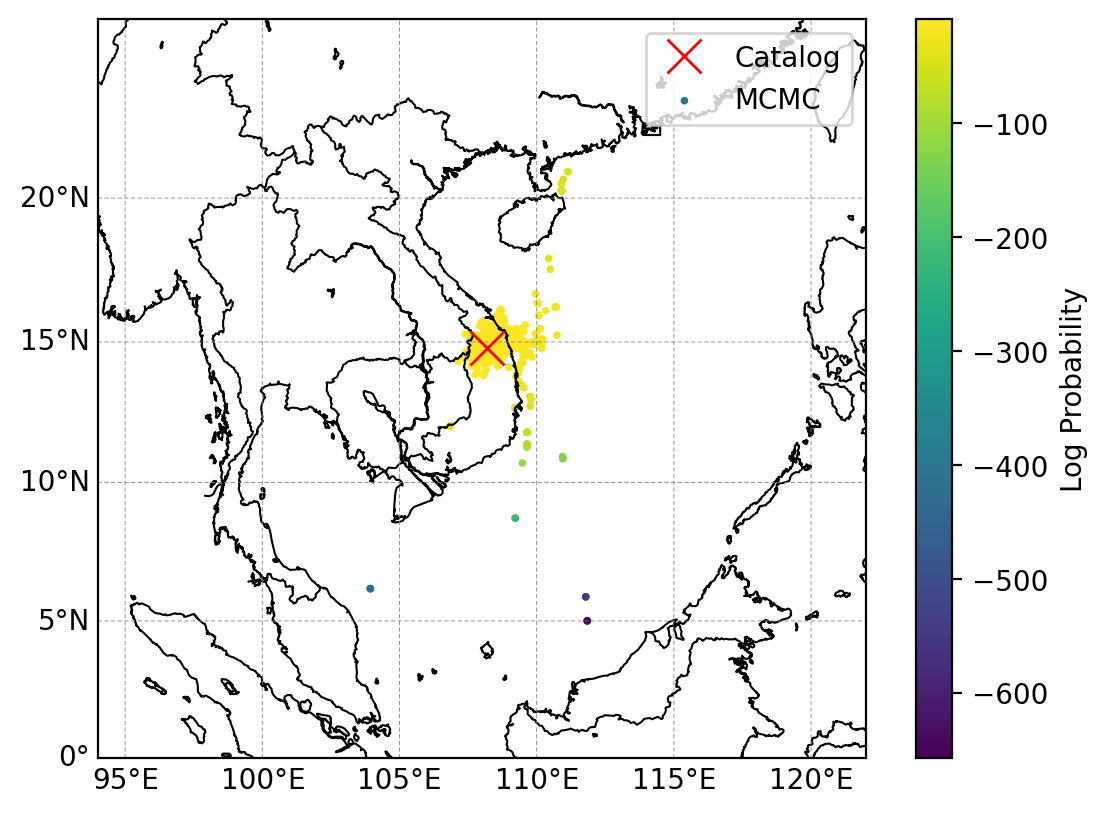

In [ ]:

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
# for key, val in picks.items():
#     m.plot(val['x'], val['y'], '^', c='magenta', markersize=8)
#     ax.text(val['x'], val['y']+4e4, key, fontsize='small', color='r', ha='center')

# plot the epicenter
m.plot(S0[1], S0[0], 'x', markersize=12, label='Catalog', mec='r', latlon=True)

# plot the epicenter
# sols = sampler.get_chain(flat=True)
# lprob = sampler.get_log_prob(flat=True)
mappable = m.scatter(sols[:,1], sols[:,0], label='MCMC', c=lprob, latlon=True, s=3)

plt.colorbar(mappable, label='Log Probability')

ax.legend()
# show the plot
plt.show()